# Scaling with the number of environments

In this notebook, we will look at the difference in **THROUGHPUT** between MiniGrid and NAVIX environments: how the performance scales with the number of environments.
We will still use random actions, but the environments now run in batch mode.

#### TL;DR;

NAVIX can scale up to over **$2M$ environments** in parallel in **less than $10$s**, less than the time required by MiniGrid to run a single environment.

---

#### Benchmarking MiniGrid

Let's start with MiniGrid.

In [1]:
import os
os.environ['PYGAME_HIDE_SUPPORT_PROMPT'] = "hide"
# See https://stackoverflow.com/questions/51464455/how-to-disable-welcome-message-when-importing-pygame

In [ ]:
import time
import timeit
import gymnasium as gym
import matplotlib.pyplot as plt
from minigrid.wrappers import ImgObsWrapper

def benchmark_minigrid(num_envs):
    env = gym.make_vec(
        "MiniGrid-Empty-8x8-v0",
        num_envs=num_envs,
        wrappers=[ImgObsWrapper],
    )
    env.reset()

    for _ in range(1_000):
        action = env.action_space.sample()
        timestep = env.step(action)
    return timestep


minigrid_times = {}
i = 2
while True:
    try:
        minigrid_times[i] = timeit.timeit(lambda: benchmark_minigrid(i), number=1)
        time.sleep(1)
        i *= 2
    except:
        print("Max num_envs reached", i)
        break

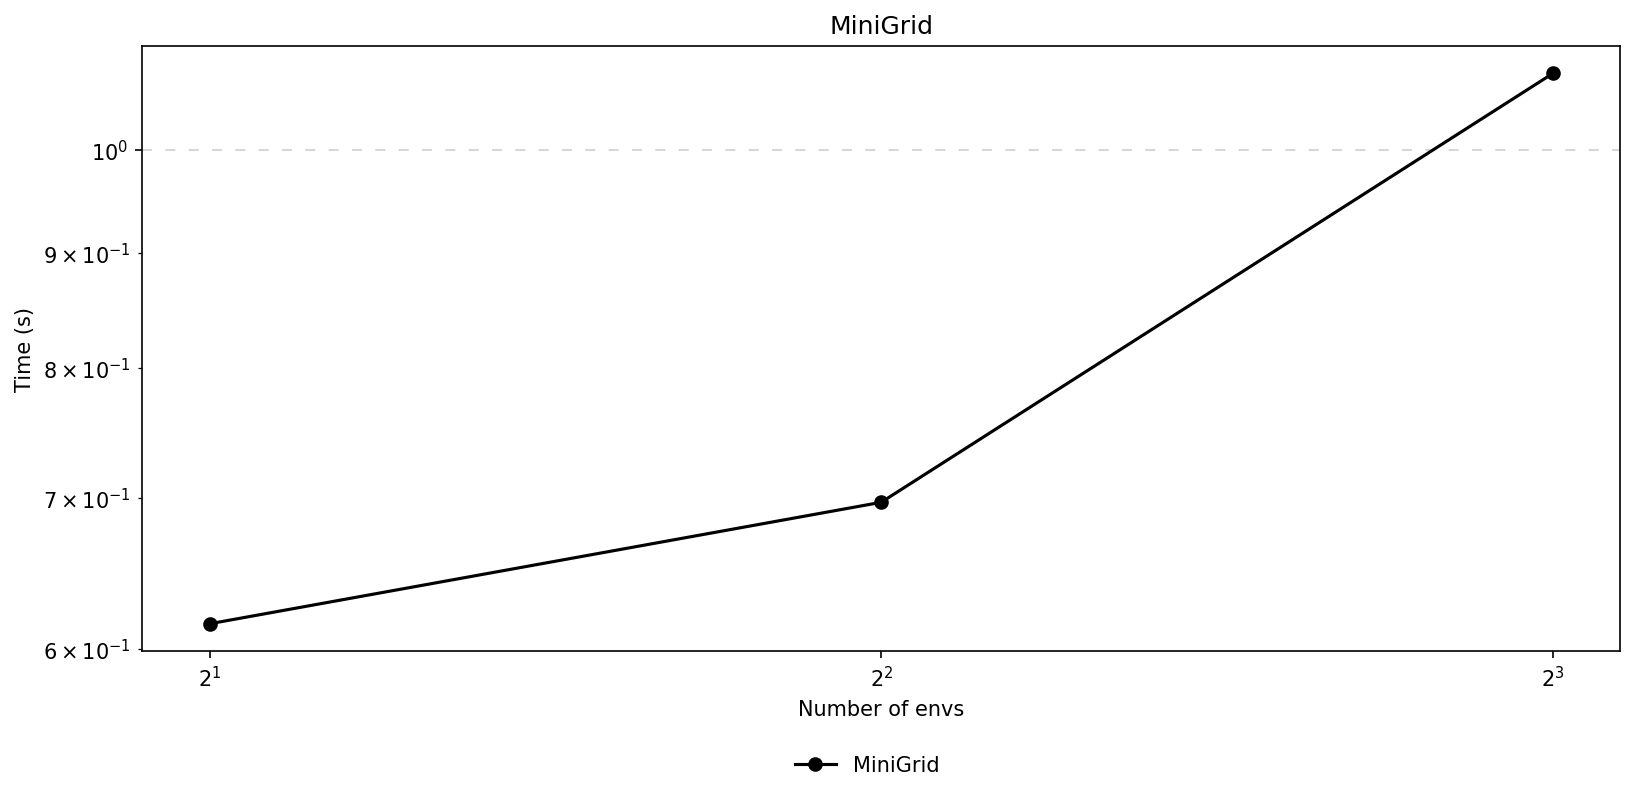

In [41]:
fig, ax = plt.subplots(figsize=(11, 5), dpi=150)
ax.plot(minigrid_times.keys(), minigrid_times.values(), label="MiniGrid", color="black", marker="o")
ax.set_xlabel("Number of envs")
ax.set_ylabel("Time (s)")
ax.set_title("MiniGrid")
ax.set_yscale("log")
ax.set_xscale("log", base=2)
ax.grid(axis="y", linestyle=(0, (6, 8)), alpha=0.6)
fig.legend(loc="lower center", ncol=2, bbox_to_anchor=(0.53, -0.07), shadow=False, frameon=False)
fig.tight_layout()
plt.show()

It scales quite linearly with the number of steps. That's a reasonable time for a single environment that runs on the CPU.


#### Benchmarking NAVIX

Let's see how NAVIX compares to MiniGrid with a single environment.

In [ ]:
import jax
import navix as nx


@jax.jit
@jax.vmap
def benchmark_navix(seed):
    env = nx.make('Navix-Empty-8x8-v0') # Create the environment
    timestep = env.reset(seed)
    actions = jax.random.randint(seed, (1_000,), 0, env.action_space.n)

    def body_fun(timestep, action):
        timestep = env.step(timestep, action)  # Update the environment state
        return timestep, ()

    return jax.lax.scan(body_fun, timestep, actions, unroll=10)[0]

navix_times = {}
i = 2
while True:
    try:
        seeds = jax.random.split(jax.random.PRNGKey(0), i)
        benchmark_navix_jit = benchmark_navix.lower(seeds).compile()
        navix_times[i] = timeit.timeit(lambda: benchmark_navix_jit(seeds), number=1)
        i *= 2
    except:
        print("Max num_envs reached", i)
        break

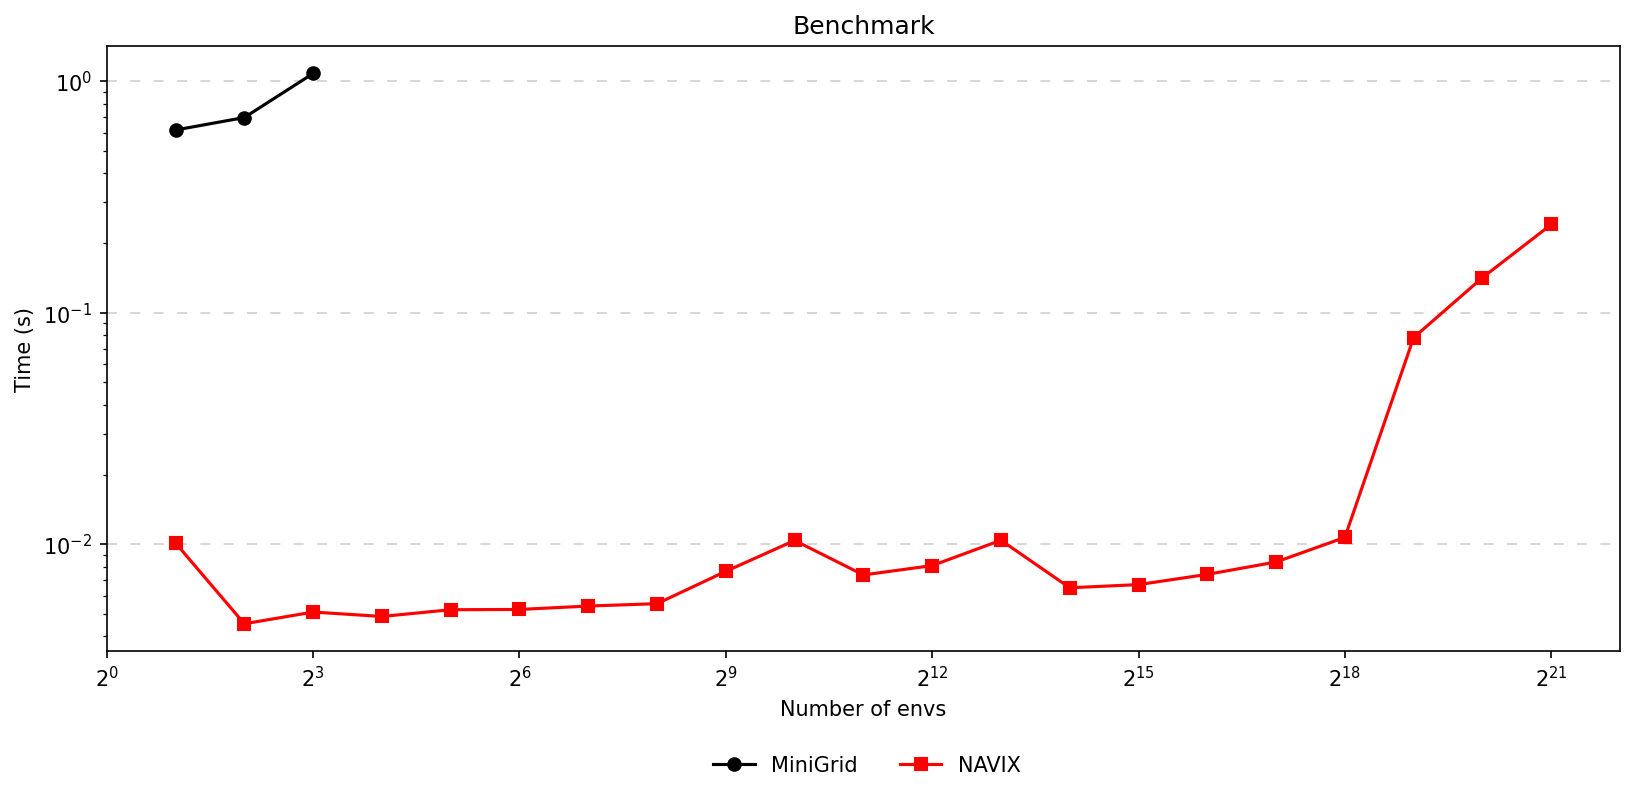

In [44]:
fig, ax = plt.subplots(figsize=(11, 5), dpi=150)
ax.plot(minigrid_times.keys(), minigrid_times.values(), label="MiniGrid", color="black", marker="o")
ax.plot(navix_times.keys(), navix_times.values(), label="NAVIX", color="red", marker="s")
ax.set_xlabel("Number of envs")
ax.set_ylabel("Time (s)")
ax.set_title("Benchmark")
ax.set_yscale("log")
ax.set_xscale("log", base=2)
ax.grid(axis="y", linestyle=(0, (6, 8)), alpha=0.6)
fig.legend(loc="lower center", ncol=2, bbox_to_anchor=(0.53, -0.07), shadow=False, frameon=False)
fig.tight_layout()
plt.show()

## Conclusions

NAVIX can scale up to $2^{21} = 2097152$ environments (over $2M$ environments in parallel!) and still do that in less than the time required by MiniGrid to run a single environment.